<< [第六章：文本和序列的深度学习](Chapter6_Deep_learning_for_text_and_sequences.ipynb)|| [目录](index.md) || [第八章：生成模型深度学习](Chapter8_Generative_deep_learning.ipynb) >>

# 第七章：高级深度学习最佳实践

> In this chapter, we cover more advanced techniques for designing and manipulating deep
neural networks:

> -The Keras functional API, with which you will be able to build graph-like models, share
a same layer across different inputs, and use Keras models just like Python functions.
- Keras callbacks, and the TensorBoard browser-based visualization tool, to monitor
models during training.
- Important best practices such as batch normalization, residual connections,
hyperparameter optimization, and model ensembling.

在本章中，我们会介绍更多设计和操作深度神经网络的高级技巧：

- Keras的函数API，它们允许你能够构建图神经模型，在多个输入中共享相同的层，然后就像使用Python函数那样使用Keras模型。
- Keras回调，以及TensorBoard的Web可视化工具，来监控模型训练过程。
- 一些重要的最佳实践包括批归一化，残差连接，超参数优化和模型组装。

> These are powerful tools that will bring you closer to being able to develop
state-of-art models on difficult problems.

这些强大的工具可以让你能够在困难问题上从细节开始设计开发更加先进的模型。

## 7.1 超越序列模型：使用Keras函数API

> Until now, all neural networks introduced in this book have been implemented using the
Sequential model. The Sequential model makes the assumption that the network has
exactly one input and exactly one output, and that it consists of a linear stack of layers.

直到目前，本书介绍的所有神经网络都是使用序列模型构建的。这种模型假设你的网络正好只有一个输入和一个输出，因此它只包含线性堆叠的层。

![sequential model](imgs/f7.1.jpg)

图7-1 序列模型

> This is a very commonly verified assumption; this configuration is in fact so common
that we have been able to cover many topics and practical applications in these pages so
far using only the Sequential model class. However, this set of assumptions is too
inflexible in a number of cases. Some networks require several independent inputs, some
others require multiple outputs, and some networks have internal branching between
layers making them look like graphs of layers rather than linear stacks of layers.

这是一个非常普遍并经过验证的假设：这样的配置事实上是如此的普遍，我们仅使用序列模型就能覆盖许多的主题和实际应用。然而，这样的假设在一些场景中就显得不够灵活了。一些网络需要多个独立的输入，其他一些需要多个输出，还有一些网络在层次之间会存在分支，使得它们看起来更像一张图，而不是层次的线性堆叠。

> Some tasks, for instance, require multi-modal inputs: they merge data coming from
different input sources, processing each type of data using different kinds of neural
layers. Imagine a deep learning model trying to predict the most likely market price of a
second-hand piece of clothing, using as input: 1) some user-provided metadata (such as
the brand, the age, etc.), 2) a user-provided text description, and 3) a picture of the item.
If we only had the metadata available, we could one-hot encode it and use a
densely-connected network to predict the price. If we only had the text description
available, we could use a RNN or a 1D convnet. If we only had the picture, we could use
a 2D convnet. But how can all leverage all three at the same time? A naive approach
would be to train three separate models, and then do a weighted average of their
predictions. However, this may well be suboptimal, because the information extracted by
the models may be high redundant. A better way is to jointly learn a more accurate model
of the data by using a model that can see all available input modalities simultaneously: a
model with three input branches (see Figure 7.2).

比如说有一些任务需要多模态输入：它们从不同的输入源中合并数据，使用不同类型的神经层来处理每种数据。设想一个深度学习模型试图预测二手衣物的可能市场价格，可能使用这些输入：1）一些用户提供的元数据（如品牌，使用时间等），2）一个用户提供的文本描述以及3）物品的照片。如果我们仅仅有元数据的话，我们可以使用one-hot对其进行编码然后使用一个全连接网络来预测价格。如果我们仅仅有文字描述数据的话，我们可以使用一个RNN或1D卷积网络。如果我们仅仅有照片数据的话，我们可以使用一个2D卷积网络。但是如果能够在一个网络中同时平衡三种输入数据呢？有一种原始的解决办法，分别训练三个独立的模型，然后将它们输出的预测值进行加权平均。但是这个方法是非常低效的，因为从每个模型中提取到的信息可能是高度冗余的。一个更好的方法是使用一个能够同时观察所有的输入数据，并联合进行学习：也就是一个具有三个输入分支的模型（参见图7-2）。

![multi-input model](imgs/f7.2.jpg)

图7-2 一个具有多个输入的模型

> Similarly, some tasks require predicting multiple target attributes of some input data.
Given the text of a novel or short-story, one might want to automatically classify it by
genre (e.g. romance, thriller) but also predict the approximate date it was written. Of
course, one could simply train two separate models, one for the genre and one for the
date. However, because these attributes are not statistically independent, we can build a
better model by learning to jointly predict both genre and date at the same time. Such a
joint model would then have two outputs, or two "heads" (Figure 7.3). Due to
correlations between genre and date, knowing the date of a novel will help the model
learn rich and accurate representations of the space of novel genres, and reciprocally.

类似的，有些任务需要对一些输入数据预测多个目标属性。给定小说或者短片故事的文本，一个任务可能需要将它们自动分类（如爱情、惊恐），还需要预测它们写成的年代。当然，你也可以简单的训练两个独立模型来处理，一个分类一个预测年代。但是因为这些属性并不是统计学独立的，所以我们可以构建一个更好的模型，同时训练两个目标。这样的联合模型就具有两个不同的输出，或者叫做两个“头”（图7-3）。由于分类和年份直接的互相关联，知道了小说写成的年代能够帮助模型获得更加丰富和准确的分类空间信息，反之亦然。

![multi-output model](imgs/f7.3.jpg)

图7-3 一个具有多输出（多头）的模型

> Additionally, many recent neural architectures require non-linear network topology:
networks structured as directed acyclic graphs. The Inception family of networks
(developed by Szegedy et al. at Google), for instance, relies on "Inception modules",
where the input is processed by several parallel convolutional branches whose outputs
then get merged back into a single tensor (Figure 7.4). There is also the recent trend of
adding "residual connections" to a model, which started with the ResNet family of
networks (developed by He et al at Microsoft). A residual connection consists simply in
reinjecting previous representations into the downstream flow of data, by adding a past
output tensor to later output tensor (Figure 7.5), which helps prevent information loss
along the data processing flow. And there are many more examples of such graph-like
networks.

还有就是进来很多神经网络结构需要非线性网络拓扑：网络具有有向无环图结构。例如神经网络中的感知家族（由Google的Szegedy发明的），依赖其中的“感知模块”，会将输入处理成多个并行的卷积分支，它们的输出之后会被重新合并到一个张量中（图7-4）。最近也有一个趋势需要在模型中增加“残差连接”，广泛应用在神经网络中的ResNet家族（由微软的He发明的）。一个具有残差连接的模型可以简单地将之前的表现形式再次诸如到下游的数据流中，通过将之前的输出张量加入到后续的输出张量当中（图7-5），可以避免在数据处理流中产生信息损失。除此之外，还有很多其他的图神经网络的形式。

![inception module](imgs/f7.4.jpg)

图7-4 感知模块：由多个并行卷积层分支组成的图网络结构

![residual connections](imgs/f7.5.jpg)

图7-5 残差连接：通过特征地图相加将之前输出数据再次注入下游数据中

> These three important use cases—multi-input models, multi-output models, and
graph-like models—are not possible when using only the Sequential model class in
Keras. But there is also a different, far more general and flexible way to use Keras: the
functional API . This sections explains in detail what it is, what it can do, and how to use
it.

这三种重要的应用场景：多输入模型，多输出模型和图网络模型，在使用Keras的序列模型的情况下都是无法实现的。不过Keras还提供了一个不同的，但更加通用和灵活的方法来满足这些场景：函数API。这个小节会详细介绍它是什么，它能做什么和如何使用。

### 7.1.1 函数API介绍

> In the functional API, you are directly manipulating tensors, and you use layers as
functions that take tensors and return tensors (hence the name "functional API").

在函数API中，你将要直接操纵张量，模型的层会当成函数一样来使用，接受张量和返回张量（因此命名为“函数API”）。

In [1]:
from tensorflow.keras import Input, layers

# 定义一个张量
input_tensor = Input(shape=(32,))

# 一个网络层就是一个函数
dense = layers.Dense(32, activation='relu')

# 层次可以使用张量来调用，并返回一个张量
output_tensor = dense(input_tensor)

> Let’s start with a minimal example: we will show side by side a simple Sequential
model and its equivalent in the functional API.

让我们从一个最简单的例子开始：我们展示一个简单的序列模型和它对等的函数API模型。

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, Input

# 下面是一个序列模型，你应该已经完全了解了
model = Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# 下面是与其对等的函数API模型
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

# 使用Model类将输入张量和输出张量转换成一个模型
model = Model(input_tensor, output_tensor)

# 看一下模型的情况
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


> The only part that may seem a bit magical at this point is instantiating a Model object
using only an input tensor and output tensor. Behind the scenes, Keras will retrieve every
layer that was involved in going from input_tensor to output_tensor , bringing them
together into a graph-like data structure—a Model . Of course, the reason it works is
because output_tensor was indeed obtained by repeatedly transforming input_tensor
. If you tried to build a model from inputs and outputs that were not related, you would
get a RuntimeError :

上面的代码中唯一看起来有点像魔术的就是使用输入张量和输出张量来初始化模型对象部分。在实现中，Keras会获取每一个涉及从输入张量计算得到输出张量需要用到的层次，将它们组合在一起构建一个图网络数据结构，也就是模型。当然，这能够实现的原因是输出张量确实能够通过输入张量经过有限次的计算后得到。如果你尝试构建一个模型，其输入和输出是不相关的，就会得到一个RuntimeError：

译者注：新版的Keras将错误改成了ValueError。

In [3]:
unrelated_input = Input(shape=(32,))
bad_model = Model(unrelated_input, output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_2:0", shape=(None, 64), dtype=float32) at layer "input_2". The following previous layers were accessed without issue: []

> This error tells you, in essence, that Keras was not able to reach input_1 from the
provided output tensor.

这个错误告诉你，Keras无法从input_2获取能够到达输出张量的路径。

> When it comes to compiling, training or evaluating such an instance of Model , the
API is the same as that of Sequential :

当对这样的模型进行编译、训练和评估时，使用的是与序列模型相同的API：

In [4]:
# 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 创建一个随机Numpy张量来进行训练
import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))

# 训练模型
model.fit(x_train, y_train, epochs=10, batch_size=128)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 352us/sample - loss: 11.9589
Epoch 2/10
1000/1000 [==============================] - 0s 13us/sample - loss: 12.6993
Epoch 3/10
1000/1000 [==============================] - 0s 33us/sample - loss: 14.2038
Epoch 4/10
1000/1000 [==============================] - 0s 28us/sample - loss: 15.9779
Epoch 5/10
1000/1000 [==============================] - 0s 14us/sample - loss: 17.5353
Epoch 6/10
1000/1000 [==============================] - 0s 29us/sample - loss: 19.7986
Epoch 7/10
1000/1000 [==============================] - 0s 12us/sample - loss: 22.6058
Epoch 8/10
1000/1000 [==============================] - 0s 24us/sample - loss: 26.4214
Epoch 9/10
1000/1000 [==============================] - 0s 22us/sample - loss: 30.4819
Epoch 10/10
1000/1000 [==============================] - 0s 9us/sample - loss: 35.1275


In [5]:
# 评估模型
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 103us/sample - loss: 37.9977


37.997671295166015

### 7.1.2 多输入模型

> The functional API can be used to build models that have multiple inputs. Typically, such
models will at some point "merge" their different input branches using a layer that can
combine several tensors, i.e. by adding them, concatenating them, etc. This is usually
done via a Keras "merge operation" such as keras.layers.add ,
keras.layers.concatenate , etc. Let’s take a look at a very simple example of a
multi-input model: a question-answering model.

上面介绍的函数API可以用来构建具有多个输入的模型。特别是这样的模型会在某个点“合并”它们不同的输入分支，这里使用了一种能够组合多个张量的层，实际上就是将这些张量相加或者级联等。这个层次通常使用Keras的“合并操作”或“级联操作”完成，也就是keras.layers.add或者keras.layers.concatenate等函数。下面让我们看一个非常简单的多输入模型例子：回答问题模型。

> A typical question-answering model has two inputs: a natural language question, and
a text snippet (such as a news article) providing information to be used for answering the
question. The model must then produce an answer: in the simplest possible setup, this is
simply a one-word answer obtained via a softmax over some predefined vocabulary. This
is presented in Figure 7.6.

一个典型的问答模型有两个输入：一个自然语言的问题，和一个文本片段（例如一篇新的文章）提供了用来回答问题的信息。这个模型然后输出一个回答：在最简单的配置中，这就是一个单词的回答，使用softmax在一些预定义的词汇表中选取得到。正如图7-6所示。

![question-answer model](imgs/f7.6.jpg)

图7-6 一个问答模型

> Here is an example of how we can build such a model with the functional API: we set
up two independent branches, encoding the text input and the question input as
representation vectors, then we concatenate these vectors, and finally, we add a softmax
classifier on top of the concatenated representations.

下面是一个例子，展示我们使用函数API来构建这样的模型：我们构建两个独立的分支，将输入的参考文本和问题编码成向量，然后将这些向量级联起来，最后我们使用一个softmax分类器来获得最终的输出结果。

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

text_vocabulary_size = 10_000
question_vocabulary_size = 10_000
answer_vocabulary_size = 500

# 这里的参考文本输入是一段可变长度的文字，我们还可以为输入张量命名
text_input = Input(shape=(None,), dtype='int32', name='text')

# 我们将文本嵌入到一个形状为64的向量中
embedded_text = layers.Embedding(64, text_vocabulary_size)(text_input)

# 然后我们将它通过LSTM编码成一个独立向量
encoded_text = layers.LSTM(32)(embedded_text)

# 下面按照同样的方法处理问题文本
question_input = Input(shape=(None,), dtype='int32', name='question')
embedded_question = layers.Embedding(32, question_vocabulary_size)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)

# 然后将两个输入得到的输出张量级联
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)

# 最顶层是一个全连接层，使用softmax激活，得到答案
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

# 初始化模型实例时，我们使用两个输入和一个输出
model = Model([text_input, question_input], answer)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

> Now, how do we train this two-input model? There are two possible APIs: you could
feed as inputs to the model a list of Numpy arrays, or you could feed it a dictionary
mapping input names to Numpy arrays. Naturally, the latter option is only available if
you gave names to your inputs.

下面，我们应该如何训练这个双输入的模型呢？这里有两种可用的API：你可以将一个Numpy数组的列表作为输入给模型，或者你可以将一个输入名称和Numpy数组值的字典作为输入给模型。当然后一种方式仅在你指定了输入名称的情况下有效。

译者注：以下代码在tensorflow 2上无法运行。

In [ ]:
import numpy as np

num_samples = 1000
max_length = 100

# 我们构建一些随机Numpy数组来训练模型
text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))

# 答案是one-hot编码的，不是整数
answer = np.random.randint(0, 1, size=(num_samples, answer_vocabulary_size))

# 使用Numpy数组列表代入
model.fit([text, question], answer, epochs=10, batch_size=32)

# 使用字典代入，仅在设定了输入名称时有效
model.fit({'text': text, 'question': question}, answer, epochs=10, batch_size=128)

### 7.1.3 多输出模型

> In the same way, the functional API can be used to build models with multiple outputs
(or multiple "heads", as sometimes described in the literature). A simple example would
be a network that attempts to simultaneously predict different properties of the data: let’s
say, a network that takes as input a series of social media posts from one single
anonymous person, and tries to predict attributes of that person, such as age, gender, or
income level (Figure 7.7).

同样的可以使用函数API来构建具有多个输出（在一些文献中也叫做多个“头”）的模型。一个简单的例子是模型可能需要同时预测数据集的多个不同的特征：比如一个接受某个匿名用户的社交媒体数据的网络，并尝试从这些数据当中预测该用户的年龄、性别或者收入情况。

![multi-output network](imgs/f7.7.jpg)

图7-7 一个三头的社交媒体分析网络

In [7]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(256, vocabulary_size)(posts_input)

x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 注意下面我们给输出张量命名了
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input, [age_prediction, income_prediction, gender_prediction])

> Importantly, training such a model requires the ability to specify different loss
functions for different "heads" of the network: for instance, age prediction is a scalar
regression task, but gender prediction is a binary classification task, requiring a different
training procedure. However, since gradient descent requires us to minimize a scalar , we
must combine these losses into a single value in order to be able to train the model. The
simplest way to combine different losses is simply to sum them all. In Keras, you can use
either a list or a dictionary of losses in compile to specify different objects for different
outputs, and the resulting loss values get summed into a global loss, which is what gets
minimized during training.

对于上面这样的网络来说，有一个重点在于它需要能够对每个不同的“头”设定不同的损失函数：例如，预测年龄是一个标量回归任务，而预测性别是一个二分分类任务，它们需要不同的训练过程。然而因为梯度下降算法需要能够最小化一个标量，我们必须将这些损失合并成单一值才可以训练模型。最简单的方式是将它们加起来。你可以在Keras中使用一个列表或者字典值作为损失参数传递到模型编译函数中，这样能够简单的将损失值相加，最终使用梯度下降来进行训练。

In [8]:
model.compile(optimizer='rmsprop', 
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# 或者当你指定了输出名称时，可以使用字典值参数
model.compile(optimizer='rmsprop', 
              loss={
                  'age': 'mse', 
                  'income': 'categorical_crossentropy',
                  'gender': 'binary_crossentropy',
              })

> Note that it is also possible to assign different importances to the loss values in their
contribution to the final loss. This is useful in particular if the different losses take values
on different scales. For instance, the MSE loss used for the age regression task could take
a typical value around 3-5, while the crossentropy loss used for the gender classification
task could be as low as 0.1. In such a situation, in order to make the contribution of the
different losses more balanced, you would assign a weight of 10 to the crossentropy loss,
and a weight of 0.25 to the MSE loss. Very imbalanced loss contributions would cause
the model representations to be optimized preferentially for the task with the largest
individual loss, at the expense of the other tasks.

还要知道的是，也可以指定各个损失值的重要程度，也就是各损失对于整体损失的权重。这对于损失值处于不同取值区间的情况下非常有用。例如，用来进行年龄回归的任务使用MSE损失，很可能具有取值范围3-5，而用来进行年龄分类的任务使用交叉熵损失，取值范围很可能低至0.1。在这种情况下为了使得各自对于总体损失的贡献更加平衡，你可以设定交叉熵具有权重10，而MSE具有权重0.25。极度不平均的损失值取值分布可能造成某个特定任务性能得到很大优化，而牺牲了其他任务的性能。

In [9]:
model.compile(optimizer='rmsprop', 
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[.25, 1., 10.])

# 或者
model.compile(optimizer='rmsprop', 
              loss={
                  'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy',
              }, 
              loss_weights={
                  'age': .25,
                  'income': 1.,
                  'gender': 10.,
              })

> Much like in the case of multi-input models, passing Numpy data to the model for
training can be done either via a list of arrays or via a dictionary of arrays:

正如多输入模型中看到的，可以使用Numpy数组列表或者数组字典的方式将数据传入模型进行训练：

译者注：下面代码无法真正运行。

In [ ]:
# 这里假设posts是输入Numpy数组，age_targets, income_targets和gender_targets是对应的目标标记
model.fit(posts, [age_targets, income_targets, gender_targets], 
          epochs=10, batch_size=128)

# 或者
model.fit(posts, {
    'age': age_targets,
    'income': income_targets,
    'gender': gender_targets,
}, epochs=10, batch_size=128)

### 7.1.4 层次的有向无环图

> With the functional API, not only can you build models with multiple inputs and multiple
outputs, you can also implement networks with a complex internal topology. Neural
networks in Keras are allowed to be arbitrary directed acyclic graphs of layers. The
qualifier "acyclic" is important: these graphs cannot have cycles, i.e. to is impossible for
a tensor x to become the input of one of the layers that generated x ). The only processing
"loops" that are allowed (i.e. recurrent connections) are those internal to recurrent layers.

使用函数API不但能够让你构建具有多个输入和多个输出的模型，还能构建具有更加复杂的内部拓扑结构的网络。Keras中可以构建任意有向无环图的神经网络。这里的“无环”是非常重要的：这些图结构当中不能存在循环，也就是说不允许任何产生x张量的层能够接受x作为输入张量。这里唯一能够接受的循环只能处于循环层的内部。

> Several common neural network components are implemented as graphs. Two
notable ones are Inception modules, and residual connections. To better understand how
the functional API can be used to build graphs of layers, let’s take a look at how we can
implement both of them in Keras.

有一些常见的神经网络组件是使用图实现的。其中两个最著名的就是感知模块和残差连接。为了更好的理解函数API如何构建层次的图模型，我们下面来看看如何在Keras中实现这两个组件。

#### 感知模块

> Inception is a popular type of network architecture for convolutional neural networks,
developed by Christian Szegedy and colleagues at Google in 2013-2014, inspired by the
earlier "network-in-network" architecture. It consists of a stack of modules which
themselves look like small independent networks, split into several parallel branches. The
most basic form of an inception module has three to four branches starting with a 1x1
convolution, following up with a 3x3 convolution, and ending with the concatenation of
the resulting features. This setup helps the network separately learn spatial features and
channel-wise features, which is more efficient than learning them jointly. More complex
versions of an Inception module are also possible, typically involving pooling operations,
different spatial convolution sizes (e.g. 5x5 instead of 3x3 on some branches), and
branches without a spatial convolution (only a 1x1 convolution). An example of such a
module, taken from Inception V3, is provided in Figure 7.8.

感知是卷积神经网络结构中很常见的一种类型，它是有Christian Szegedy和他的谷歌同事在2013-2014年发明的，其原理启发自早期的“网络中的网络”结构。它含有一系列堆叠的层次，令其看起来像一个小型的独立网络，分成多个并行的分支。最基础的感知模块的形式一般有三到四个分支，从一个1x1的卷积层开始，接着一个3x3的卷积层，最终将结果特征级联起来，这样会比顺序的训练得到特征要高效。更复杂的感知模块也存在，可能包含池化操作和不同的空间卷积尺寸（如在一些分支中是5x5而不是3x3的卷积层），以及某些分支不包括空间卷积操作（只含有1x1卷积层）。图7-8展示了这样的一个例子，也就是Inception V3的结构。

![inception module](imgs/f7.8.jpg)

图7-8 一个感知模块

------

##### 注：1x1卷积（也称为点卷积）的作用

> You already know that convolutions extract spatial patches around every
tile in an input tensor, and apply a same transformation to each patch. An
edge case is when the patches extracted consist of a single tile. The
convolution operation then becomes equivalent to running each tile vector
through a Dense layer: it will compute features that mix together
information from the channels of the input tensor, but it will not mix
information across space at all (since it is looking at one tile at a time).
Such 1x1 convolutions are featured in Inception modules, where they
contribute to factoring out channel-wise feature learning and space-wise
feature learning—a reasonable thing to do if you assume that each
channel is highly auto-correlated across space, but different channels
might not be highly correlated with each other.

你已经了解卷积能够提取输入张量中的每个部分的空间特征，并且在每个局部应用相同的变换。极端情况就是当提取特征的部分仅含有一个像素点。这时候卷积操作就变成了在每个点向量上应用全连接层：它会计算那些输入张量中各点不同通道的特征，而不会计算那些与空间相关的任何特征（因为每次只会观察一个点）。这样的1x1卷积在感知模块中被广泛使用，因为它们能够提供通道特征提取和空间通道相关特征信息，如果假设空间中相同的通道都是高度相关的，而不同的通道却是非高度相关的前提下，这种模型就是非常自然的。

------

> Here is how one would implement the module featured in Figure 7.4 using the
functional API:

下面是使用函数API实现图7-8的网络的代码：

译者注：以下代码无法执行。

In [ ]:
from tensorflow.keras import layers

# 下面我们假设已经存在一个4D的张量x

# 每个分支的步进都是2，这是必须的，才能使得最终每个分支的输出张量的形状是一致的
# 从而能够级联这些结果张量
branch_a = layers.Conv2D(128, 1, activation='relu', strides=2)(x)

branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

branch_c = layers.AvgPooling2D(3, strides=2, activation='relu')(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 3, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_d)

# 最后我们级联所有分支的结果张量得到整个模块的输出
output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

> Note that the full Inception V3 architecture is available in Keras as
keras.applications.inception_v3.InceptionV3 , including weights pre-trained on
the ImageNet dataset. Another closely related model available as part of the Keras
applications module is Xception . "Xception", which stands for "extreme inception", is a
convnet architecture loosely inspired by Inception. It takes the idea of separating the
learning of channel-wise and space-wise features to its logical extreme, and replaces
Inception modules with depthwise separable convolutions, consisting in a depthwise
convolution (a spatial convolution where every input channel is handled separately)
followed by a pointwise convolution (i.e. a 1x1 convolution)—effectively, an extreme
form of an Inception module, where spatial features and channel-wise features are fully
separated. Xception has roughly the same number of parameters of Inception V3, but it
shows better runtime performance and higher accuracy on ImageNet as well as other
large-scale datasets, due to a more efficient use of model parameters.

需要说明的是完整的Inception V3结构可以直接使用Keras内置的`applications.inceptions.inception_v3.InceptionV3`类，并且内置了从ImageNet数据集中预训练的网络权重参数。还有一个很接近的模型同样也内置在Keras当中，就是application里面的Xception模块。“Xception”代表“extreme Inception”，是一个由Inception结构启发得到卷积网络结构。它采用的是彻底分离通道学习和空间学习的方式，将感知模块替换成深度可分离的卷积层，组成一个深度卷积网络（每个输入通道都是分别处理的空间卷积）然后接着一个点卷积层（也就是一个1x1卷积）。简单来说就是感知模块的极端形式，其中的空间特征和通道特征都是完全分离的。Xception模型的参数与Inception V3的参数个数大致相同，但它在ImageNet和其他一些大型数据集上的效率和性能准确率都超过了Inception V3，因为它能够更加有效的使用模型的参数。

#### 残差连接

> Residual connections are a very common graph-like network component found in many
post-2015 network architectures, including Xception. They were introduced by He et al
from Microsoft in their winning entry in the ILSVRC ImageNet challenge in late 2015.
They tackle two common problems that plague any large-scale deep learning model:
vanishing gradients, and representational bottlenecks. In general, adding residual
connections to any model that has over ten layers is likely to be beneficial.

残差连接是2015年后很流行的图状神经网络结构组件，包括Xception。这个方法是微软的He在2015年底赢得ILSVRC ImageNet挑战比赛的首先提出的。它解决了两个任何大型深度学习模型最主要的问题：梯度消失和表现性瓶颈。通常来说，在任何超过10层的模型上增加残差连接都能够获得更好的结果。

> A residual connection simply consist of making the output of an earlier layer
available as input to a later layer, effectively creating a shortcut in a sequential network
(Figure 7.5). Rather than being concatenated to the later activation, the earlier output is
summed with the later activation, which assumes that both activations have the same
size. In case of differing sizes, one may use a linear transformation to reshape the earlier
activation into the target shape (e.g. a Dense layer without an activation, or for
convolutional feature maps, a 1x1 convolution without an activation).

一个残差连接组件简单来说就是能够将之前层次的输出作为再后续层次的输入，也就是在序列网络中创建一个短路机制（参见图7-5）。前面层次的输入将会直接加到后续的激活输出中而不是级联起来，因此需要假设两次激活的输出具有相同的形状。在不同形状的情况下，可以使用线性转换将前面层次的输出变成目标形状（例如一个全连接层不带激活函数，或者对于卷积特征地图，一个1x1的卷积不带激活函数）。

> Here is how you would implement a residual connection in Keras:

下面是使用Keras实现残差连接的代码：

译者注：下面的代码无法执行。

In [ ]:
# 当之前的输入和后续的输出具有相同形状时，使用单位残差连接

from tensorflow.keras import layers

# 这里假设x是一个4D输入张量
x = ...

# 下面使用一系列的卷积层来提取特征
y = layers.Conv2D(128, 3, activation='relu')(x)
y = layers.Conv2D(128, 3, activation='relu')(y)
y = layers.Conv2D(128, 3, activation='relu')(y)

# 然后将之前的输入x和y相加
y = layers.add([y, x])

In [ ]:
# 当之前的输入和后续的输出具有不同形状时，使用线性残差连接

from tensorflow.keras import layers

y = layers.Conv2D(128, 3, activation='relu')(x)
y = layers.Conv2D(128, 3, activation='relu')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# 下面需要使用一个1x1的卷积将x转换成y相同的形状
residual = layers.Conv2D(1, strides=2)(x)

# 转换后，两者可以进行相加操作
y = layers.add([y, residual])

------

##### 注：深度学习中的表现性瓶颈

> In a sequential model, each successive representation layer is built on top
of the previous one, which means that it only has access to information
contained in the activation of the previous layer. If one layer happens to
be too small (e.g. have features that are too low-dimensional), then the
model will be constrained by how much information can be crammed into
the activations of this layer. You can think of it with a signal processing
analogy: if you have an audio processing pipeline that consists of a series
of operations that each take as input the output of the previous operation,
then if one operation happens to crop your signal to a low frequency
range (e.g. 0-15 kHz), the operations downstream will never be able to
recover the dropped frequencies. Any loss of information is permanent.
Residual connections, by reinjecting earlier information downstream,
partially solve this issue for deep learning models.

在序列模型中，每个后续的表现层都是基于其上一个层次，这意味着后续层次仅能接触到那些上一层激活后留下来的信息。如果其中一个层次比较小（如仅含有低维度的特征），那么整个模型会被该层激活后能够学习到的信息限制。你可以想象一个信号处理的情景来类比：假设有一个音频处理管道，其中每一步都接受上一步音频输入并输出音频信号，这种情况下如果有一个操作将输入的音频剪裁到了一个低频段（如0-15kHz），那么下游的操作将永远无法恢复那些被裁剪掉的频率。任何信息的损失都是永久的。残差连接将先前的信息重注入到下游操作，能够部分解决深度学习模型的这个问题。

------

##### 注：深度学习中的梯度消失

> Backpropagation, the master algorithm used to train deep neural
networks, works by propagating a feedback signal from the output loss
down to earlier layers. If this feedback signal has to be propagated
through a very deep stack of layers, the signal may become very tenuous
or even be lost entirely, rendering the network untrainable—this is the
problem of "vanishing gradients". This problem occurs both with very
deep networks and with recurrent networks over very long sequences—in
both cases, a feedback signal must be propagated through a long series
of operations. You are already familiar with the solution that the LSTM
layer uses to address this problem in recurrent networks: it introduces a
"carry track" that propagates information in parallel to the main processing
track. Residual connections work in a very similar way in feedforward
deep networks, but they are even simpler: they introduce a purely linear
information carry track parallel to the main layer stack, thus helping to
propagate gradients through arbitrarily deep stacks of layers.

深度神经网络中的统治算法，反向传播，通过从模型输出的损失值依次回溯信号到网络中各个层次来更新参数。如果这个反馈信号需要反向传播回溯一个非常深的网络，这个信号会发生严重衰减甚至完全小时，结果就是网络变得完全无法训练。这就是常说的“梯度消失”问题。这个问题经常发生在非常深的网络和处理很长序列的循环网络当中。在两种情况中，反馈信号都需要经过很长的步骤操作进行传播。你已经在前面章节中了解了LSTM中解决这个问题的办法：引入一个“传输带”，与主要的处理流并行传递信息。残差连接提供了类似的方案来直接前向传输信息，但更加简单：它提供一个纯粹的线性信息传送带，并行于序列模型，因此能够在任意深度的层次之间直接传输信息。

------

### 7.1.5 层权重共享

> One more important feature of the functional API is the ability to reuse a layer instance
several time. When you call a layer instance twice, instance of instantiating a new layer
for each call, you are reusing the same weights with every call. This allows you to build
models that have shared branches—several branches that all share the same knowledge
and perform the same operations, i.e. that share the same representations, and learn these
representations simultaneously for different sets of inputs.

函数API还有一个很重要的特性是它能够多次重用一个层次。每次你重用同一个层实例，你都在使用该层相同的权重值。这可以构建一个具有共享分支的模型，多个分支都共享学习的成果并且采取相同的操作，也就是说，它们共享了相同的表现形式，同时使用不同的输入对这些表现形式进行学习。

> One example would be a model that attempts to assess the semantic similarity
between two sentences. The model would have two inputs (the two sentences to
compare) and would output a score between 0 and 1, where 0 are unrelated sentences and
1 are sentences that either identical or mere reformulations of each other. Such a model
could be useful in many applications, including de-deduplicating natural language
queries in a dialog system.

这样的例子可以假设一个模型希望评估两个句子之间的语义相似度。这个模型会有两个输入（两个需要比较的句子）然后输出一个0-1之间的分数，0代表两个句子完全不相关，1代表两个句子完全相同或者只是重新编排了语序。这样的模型可以在很多应用场景中非常有用，包括在一个对话系统中对自然语言进行去重。

> Here is how we would implement such a model using layer sharing in the Keras
functional API:

下面是我们在Keras中实现这个模型的代码：

In [10]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

# 我们只创建一个LSTM层实例
lstm = layers.LSTM(32)

# 构建左边句子输入的分支
# 左边的句子的输入，词向量的长度为128，句子长度不定，然后输入到LSTM层
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

# 构建右边句子输入的分支
# 右边句子的输入
right_input = Input(shape=(None, 128))
# 输入到同一个LSTM层，两个分支共享该层的权重
right_output = lstm(right_input)

# 下面构建上面的分类器，首先将两个分支输出级联
merged = layers.concatenate([left_output, right_output], axis=-1)
prediction = layers.Dense(1, activation='sigmoid')(merged)

model = Model([left_input, right_input], prediction)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           20608       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64)           0           lstm_2[0][0]               

> Naturally, a layer instance may be used more than once—it can be called arbitrarily
many times, reusing the same set of weights every time.

当然层实例可以被多次重用，实际上可以重用任意次数，每次都共享其权重。

### 7.1.6 模型即层次

> Importantly, in the functional API, models can be used as you would use
layers—effectively, you may think of a model as a "bigger layer". This is true of both the
Sequential and Model classes. This means that you can call a model on an input tensor,
and retrieve an output tensor:

更重要的是，使用函数API可以将模型有效地作为层次来使用，你可以认为一个模型就是一个“大层次”。这对于序列模型来说也是一样的。这意味着你能够使用输入张量调用模型然后获得一个输出张量：

```python
y = model(x)
```

> If the model has multiple input tensors and multiple output tensors, it should be called
with a list of tensors:

如果一个模型有多个输入和多个输出，那可以使用张量的列表来调用：

```python
y1, y2 = model([x1, x2])
```

> When you call a model instance, you are reusing the weights of the model—exactly
like what happens when you call a layer instance. Simply calling an instance, whether it
is a layer instance or a model instance, will always reuse the existing learned
representations of the instance—which is quite intuitive.

当你调用模型实例时，你就会重用它的权重，正如上面介绍的调用层次实例一样。通过调用实例，不管是层次还是模型实例，都会重用那些学习到的表现形式，这个很容易理解。

> One simple practical example of what you can build by reusing a model instance
would be a vision model that uses a dual camera as its input: two parallel cameras, a few
centimeters (one inch) apart from each other. Such a model could be capable of
perceiving depth, which can be useful in many applications. You shouldn’t need two
independent models for extracting visual features from the left camera and from the right
camera, before merging the two feeds. Such low-level processing can be shared across
the two inputs, i.e. done via layers that use the same weights and thus share the same
representations. Here is how you would implement this in Keras:

作为你构建一个可重用模型实例的简单例子，设想一个视觉模型使用两个摄像头作为它的输入：两个并行的摄像头，之间距离几厘米（一英寸）。这样的模型可以用来检测深度，在实践中可以应用在非常多的场景中。在这个模型中你不应该使用两个独立的模型来提取两个摄像头的视觉特征，然后在合并输出。这种底层的处理模型可以在两个输入之间共享，也就是通过共享层次的权重和相同的表现形式来完成。下面是在Keras中实现的代码：

In [11]:
from tensorflow.keras import layers, Input
from tensorflow.keras.applications import Xception

# 我们使用Xception作为视觉特征提取的模型，仅使用卷积部分
xception_base = Xception(weights=None, include_top=False)

# 我们的输入是250x250的图像，然后代入同一个Xception模型实例提取特征
left_input = Input(shape=(250, 250, 3))
left_output = xception_base(left_input)
right_input = Input(shape=(250, 250, 3))
right_output = xception_base(right_input)

# 级联输出张量
merged = layers.concatenate([left_output, right_output])

### 7.1.7 小结

> This concludes our introduction to the Keras functional API, an essential tool for building
advanced deep neural network architectures. Now you know:

> - When to step out of the Sequential API: whenever you need anything more than a
linear stack of layers.
- How to build Keras models with several inputs, several outputs, and complex internal
network topology, using the Keras functional API.
- How to reuse the weights of a layer or model across different processing branches, by
calling a same layer or model instance several times.

本节概要介绍了Keras的函数API，它是用来构建高级深度神经网络结构的重要工具。你应该理解了：

- 当你需要任何序列模型无法提供的功能时，你应该去求助于函数API。
- 如何使用Keras函数API来构建包括多个输入，多个输出和复杂内在网络拓扑结构的模型。
- 如何在不同的分支中重用层次或模型的权重，通过多次调用同一个层次或模型的实例来实现。

## 7.2 检查和监测深度学习模型：使用Keras回调和TensorBoard

> In this section, we review ways to gain greater access and control over what goes on
inside your model during training.

在这一节中，我们会深入到模型训练过程中的细节，从而获得更精细的指标和控制。

> Launching a training run on a large dataset, for tens of epochs, using model.fit() or
model.fit_generator() , can a bit like launching a paper plane: past the initial
impulse, you don’t have any control over its trajectory or its landing spot. If you want to
avoid bad outcomes (and thus wasted paper planes), it is smarter to use not a paper plane,
but a drone that will be able to sense its environment, send data back to its operator, and
automatically make stirring decisions based on its current state. The techniques we
present here will transform your call to model.fit() from a paper plane into a smart
autonomous drone able to self-introspect and dynamically take action.

使用`model.fit()`或`model.fit_generator()`（译者注：`fit_generator()`方法已经弃用，统一为`fit()`方法）对大型数据集进行多达数十次迭代的训练，有点像放飞手里的纸飞机：离手之后，你就失去了对它航线和落点的任何控制。如果你希望避免不好的结果（因为这样会浪费纸飞机），更明智的方法是不要使用纸飞机，而是改用能够感知环境的无人机，将它的数据返回给操作者，并且能够自动基于当前状态调整策略。我们本节中介绍的技巧，能够将调用`model.fit()`放飞纸飞机的方式改成放飞智能自动化的无人机，过程中能够自我感知并动态采取措施。

### 7.2.1 在训练过程中对模型使用回调

> When training a model, there are many things you can’t predict from the start. In
particular, you cannot tell how many epochs will be needed to get to an optimal
validation loss. In our examples so far, we have always adopted the strategy of training
for enough epochs that we would start overfitting, using our first run to figure out the
proper number of epochs to train for, then finally launch a new training run from scratch
using this optimal number. Of course, this is quite wasteful.

当训练模型时，有很多事情是你无法开始预计到的。一个典型例子就是你无法预测多少次迭代后能够达到最优的验证损失。在我们之前的例子中，总是采取训练足够多次迭代并产生过拟合的策略，在我们第一次训练时找到合适的迭代次数，然后使用这个值重新开启一个新的训练。显然这很浪费计算资源。

> A much better way to handle this would be stop training when we measure that the
validation loss has stopped improving. This can be achieved using a Keras "callback". A
callback is an object (a class instance implementing specific methods) that is passed to
the model in the call to fit and that is called by the model at various points during
training. It has access to all the data available about the state of the model and its
performance, and it is capable to take action, for instance interrupting training, saving a
model, loading a different weight set, or otherwise altering the state of the model.

还有一种更好的方式来处理这个问题，就是当我们观察到验证损失不再改善的时候就停止训练。这可以通过Keras的“回调”实现。回调是一个传递给模型训练时候的参数对象（一个实现了特定方法的类实例），并且在训练过程中的某些时间点会被模型调用。它能够获取模型当时的所有状态和性能参数，然后采取某种行动，比方说终止训练过程，保存模型，重新加载不同的权重集，或者直接改变模型的状态值。

> Callbacks can be used for:

> - Model checkpointing: saving the current weights of the model at different points during
training.
- Early stopping: interrupting training when the validation loss has stopped improving (and
of course, saving the best model obtained during training).
- Dynamically adjusting the value of certain parameters during training, such as the
learning rate of the optimizer.
- Logging the training and validation metrics during training, or visualizing the
representations learned by the model as they get updated. In fact, the Keras progress bar
that you are familiar with is itself a callback!
- And more...

回调可以被用在：

- 模型状态暂存：在训练的不同时间点保存当前模型的权重。
- 提前终止：当验证损失已经停止改善的时候提前终止训练（当然，会保存训练过程中获得的最佳模型）。
- 在训练中动态调整模型的某些参数值，例如优化器的学习率。
- 在训练过程中记录训练和验证指标，或者可视化模型权重更新后的学习表现形式。事实上，你已经看过很多遍的Keras进度条本身也是一个回调。
- 还有很多其他用处......

> There are a number of built-in callbacks found in the keras.callbacks module
(non-exhaustive list):

在`keras.callbacks`模块中有很多内置的回调，下面列出不完全的列表：

```python
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
```

> Let’s review a few of them to give you an idea of how to use them:
ModelCheckpoint , EarlyStopping , and ReduceLROnPlateau .

让我们使用`ModelCheckpoint`，`EarlyStopping`和`ReduceLROnPlateau`作为例子来说明它们的使用方法：

#### `ModelCheckpoint`和`EarlyStopping`回调

> You can use the EarlyStopping callback to interrupt training once a target metric being
monitored has stopped improving for a fixed number of epochs. For instance, this
callback allows you to interrupt training as soon as you start overfitting, thus allowing
you to avoid having to retrain your model for a smaller number of epochs. This callback
is typically used in combination with ModelCheckpoint , which allows to continually
save the model during training (and optionally, to save only the current best model so far,
i.e. the version of the model that achieved the best performance at the end of an epoch).

你可以在监测的目标指标在固定次数迭代后停止改善的时候，使用`EarlyStopping`回调来终止训练过程。也就是说这个回调能够在发现过拟合出现的情况下提前终止训练，因此避免了你再次使用更小的迭代次数来重新训练的过程。这个回调通常会与`ModelCheckpoint`回调结合使用，该回调能够在训练过程中持续保存模型（或者可以设置为仅保存莫钱为止最佳的模型，也就是在每次迭代结束后仅保存获得最佳性能的模型参数）。

In [12]:
from tensorflow.keras import callbacks

# `model.fit()`接受一个callbacks参数，参数是一个回调函数的列表
callbacks_list = [
    # EarlyStopping能够提早终止训练，当性能不再改善时
    callbacks.EarlyStopping(
        # monitor参数设置回调监测的指标，这里设为验证准确率
        monitor='acc',
        # patience参数设置超过几次迭代不再改善性能时，终止训练
        # 这里设置为1次迭代，也就是2次迭代不再改善即终止
        patience=1,
    ),
    # ModelCheckpoint能够在每次迭代后保存模型参数
    callbacks.ModelCheckpoint(
        # filepath参数设置保存模型参数文件的路径
        filepath='my_model.h5',
        # 下面两个参数设置每次保存验证损失最低的那个模型参数
        # 如果验证损失没有达到更低，则不会覆盖模型参数文件
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
# 编译和训练模型，以下代码无法执行

# 因为在回调中用到了准确率acc，因此它应该处在参数metrics中
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 因为在回调中用到了验证损失val_loss，因此训练时必须提供验证集
model.fit(x, y, epochs=10, batch_size=32, 
          callbacks=callbacks_list, validation_data=[x_val, y_val])

#### `ReduceLROnPlateau`回调

> You can use this callback to reduce the learning rate when the validation loss has stopped
improving. Reducing or increasing the learning rate in case of a "loss plateau" is is an
effective strategy to get out of local minima during training.

你可以使用这个回调当训练过程中验证损失停止改善时来减小学习率。在出现“损失高原”时，通过减小或者增加学习率可以有效地避免局部最优的结果。

In [14]:
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        # monitor设置监测的指标，这里是验证损失
        monitor='val_loss',
        # factor设置学习率变化的因子，这里将原来的学习率除以10
        factor=.1,
        # patience设置超过多少个迭代监测指标没改善时应用学习率变化
        patience=10,
    )
]

In [ ]:
# 编译和训练模型，以下代码无法执行

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.fit(x, y, epochs=50, batch_size=32, 
          callbacks=callbacks_list, validation_data=[x_val, y_val])

#### 自定义回调

> If you need to take any specific action during training that isn’t covered by one of the
built-in callbacks, then you should write your own callback.

如果你需要一些没有内建回调函数的行为的话，那可以自己编写回调。

> Callbacks are implemented by subclassing the class keras.callbacks.Callback .
You can then implement any number of the following transparently-named methods,
which get called at various points during training:

回调通过继承`keras.callbacks.Callback`类来实现。然后根据需要实现下面任意的方法，它们会在训练过程中不同的时间点被调用：

```python
# 每次迭代开始时调用
Callback.on_epoch_begin(logs)
# 每次迭代结束时调用
Callback.on_epoch_end(logs)

# 每个批次开始时调用
Callback.on_batch_begin(logs)
# 每个批次结束时调用
Callback.on_batch_end(logs)

# 训练开始时调用
Callback.on_train_begin(logs)
# 训练结束时调用
Callback.on_train_end(logs)
```

> These methods all get called with a logs argument, a dictionary containing
information about what the previous batch, epoch, or training run: training and validation
metrics, etc. Additionally, the callback has access to the following attributes:

> - self.model , the model instance from which the callback is being called.
- self.validation_data , the value of what was passed to fit as validation data.

这些方法都使用一个logs参数来调用，这是一个包含前一个批次、迭代或者训练信息的字典值：训练和验证指标等。除此之外回调还有着下面这些额外属性：

- `self.model`，这是调用该回调的模型实例
- `self.validation_data`，这是传递给训练过程的验证数据

> Here is a simple example of a custom callback, where we save to disk (as Numpy
arrays) the activations of every layer of the model at the end of every epoch, computed
on the first sample of the validation set:

下面是一个简单的自定义回调的例子，例子中我们将每个迭代结束时模型中每一层的激活输出（以Numpy数组的形式）保存到磁盘中，该输出是通过验证集的第一个样本计算得到的：

In [15]:
import numpy as np
from tensorflow.keras.models import Model

class ActivationLogger(callbacks.Callback):
    
    def set_model(self, model):
        # 这个方法是用来提供模型在训练之前对回调进行初始化使用的
        
        # 设置回调的model属性，用来指定是哪个模型调用的回调
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        
        # 创建一个新的属性，是返回每层输出的新模型实例
        self.activations_model = Model(model.input, layer_outputs)
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError("Requires validation_data.")
            
        # 获得验证集的第一个样本
        validation_sample = self.validation_data[0][:1]
        # 使用每层输出的模型来计算激活结果
        activations = self.activations_model.predict(validation_sample)
        
        # 保存激活输出结果
        with open('activations_at_epoch_' + str(epoch) + '.npz', 'w') as fn:
            np.savez(fn, activations)

> This is all you need to know about callbacks—the rest is technical details, which can
be easily looked up. Now you are equipped to perform any sort of logging or
pre-programmed intervention on a Keras model during training.

上面就是所有有关回调你需要知道的全部内容了，其他的一些技术细节，都能很容易找到。现在你已经装备了Keras模型训练时能够进行日志记录或预编程干预的工具了。

### 7.2.2 TensorBoard介绍：TensorFlow可视化框架

> To do good research, or develop good models, you need to get rich and frequent feedback
about what is going on inside your models during your experiments. That’s the point of
running experiments: to get information about how well a model performs—as much
information as possible. Making progress is an iterative process, a loop: you start with an
idea, then you express it as an experiment, attempting to validate or invalidate your idea.
Your run this experiment, then you process the information generated by the experiment.
This inspires your next idea. The more iterations of this loop you are able to run, the
more refined and powerful your ideas become. Keras helps you go from idea to
experiment in the least possible time, and fast GPUs help you get from experiment to
result as fast as possible. But what about processing the experiment results? That’s where
TensorBoard comes in.

要获得好的研究成果，或者发展好的模型，你需要从实验中获取更加丰富和高频的反馈数据，告诉你训练过程中你的模型到底发生了什么。这就是实验的真正目的：获得模型性能的信息，越多越好。你需要在不断的迭代中进步：首先你需要想出一个解决办法，然后将它表示成实验的方式，从而能够验证或者推翻你的这个主意。接下来你就开始运行这个实验，并且处理实验过程中产生的数据。这些数据能够启发你产生改进的方法。这样迭代实验的次数越多，你的方案就会改进的越强大。Keras能够帮助你以最快的速度从设计方案转换为实验，强大的GPU能够帮助你运行实验时最快的获得结果。但处理实验结果的领域就是TensorBoard的舞台了。

![deep learning loop](imgs/f7.9.jpg)

图7-9 深度学习循环

> In the next few paragraphs, we introduce TensorBoard, a browser-based visualization
tool that comes packaged with TensorFlow. Note that it is only available for your Keras
models when you are using Keras with the TensorFlow backend.

在下面几段内容中，我们会介绍TensorBoard，这是一个基于浏览器的可视化工具，并且随着TensorFlow一起打包。注意TensorBoard仅在你使用TensorFlow作为Keras的后端计算框架时才可用。

> The key purpose of TensorBoard is to help you visually monitor everything that goes
on inside your model during training. If you are monitoring more information than just
the final loss of your model, then you can develop a clearer vision of the model does or
doesn’t do, and you can make progress faster. TensorBoard gives you access to several
neat features, all inside your browser:

> - Visually monitoring your metrics during training.
- Visualizing your model architecture.
- Visualizing histograms of activations and gradients.
- Exploring embeddings in 3D.

TensorBoard的主要目标是帮助你对模型训练过程中的所有监控指标进行可视化。如果你在训练中监控了除了模型损失外的更多信息，那么你就能获得模型能力更清晰的认知，并且能够加快上面的循环过程。TensorBoard可以在浏览器中为你提供很多有用的特性：

- 可视化监控训练时的指标
- 可视化模型结构
- 激活输出和梯度的可视化直方图
- 在3D中展示嵌入

> Let’s demonstrate these features on a simple example. We will be training a 1D
convnet on the IMDB sentiment analysis task.

让我们使用一个简单的例子来展示这些特性。我们会在IMDB数据集上训练一个1D卷积网络来进行情绪分析。

> Below is our model, similar to the one you have seen in the last section of Chapter 6.
We only consider the top 2000 words in the IMDB vocabulary, to make word embedding
visualization more tractable.

下面使我们使用的模型，与第六章最后一节的模型相似。我们只考虑IMDB词汇表中的前2000个单词，这样可以令词嵌入可视化更加容易。

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 2000 # 仅考虑头2000个特征
max_len = 500 # 仅考虑评论中的头500个单词

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len, name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
________________________________________________

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

> Before we start using TensorBoard, we need to create a directory where we will store
log files generated by TensorBoard:

在我们使用TensorBoard之前，我们需要创建一个目录来保存TensorBoard生成的日志文件：

In [18]:
%mkdir ~/my_log_dir

> Let’s launch the training, with a TensorBoard callback instance. This callback will
write log events to disk at the specified location.

下面让我们使用TensorBoard回调实例来启动训练。这个回调会在指定的目录中写入日志事件。

In [19]:
from tensorflow.keras.callbacks import TensorBoard
import os

callbacks = [
    TensorBoard(
        # 日志存放目录
        log_dir=os.path.join(os.environ['HOME'], 'my_log_dir'),
        # 每个epoch记录一次激活直方图
        histogram_freq=1,
        # 每个epoch记录一次嵌入数据
        embeddings_freq=1,
    )
]

history = model.fit(x_train, y_train, epochs=20, 
                    batch_size=128, validation_split=0.2, callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.7190 - acc: 0.6973 - val_loss: 0.4325 - val_acc: 0.8436
Epoch 2/20
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.4526 - acc: 0.8600 - val_loss: 0.4776 - val_acc: 0.8626
Epoch 3/20
20000/20000 [==============================] - 20s 1ms/sample - loss: 0.3940 - acc: 0.8838 - val_loss: 1.6496 - val_acc: 0.7048
Epoch 4/20
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.3518 - acc: 0.9033 - val_loss: 0.5879 - val_acc: 0.8564
Epoch 5/20
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.2812 - acc: 0.9254 - val_loss: 0.6506 - val_acc: 0.8572
Epoch 6/20
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.2571 - acc: 0.9369 - val_loss: 0.6156 - val_acc: 0.8682
Epoch 7/20
20000/20000 [==============================] - 25s 1ms/sample - loss: 0.2150 - acc: 0.9557 - val_loss: 0.7

> At this point, you can launch the TensorBoard server from the command line,
instructing it to read the logs the callback is currently writing. The tensorboard utility
should have been automatically installed on your machine the moment you installed
TensorFlow (e.g. via pip ).

现在就能在终端中启动TensorBoard服务了，通过参数指定日志记录所在的目录。tensorboard服务程序应该在你安装TensorFlow的时候就自动安装了（例如通过pip）。

```bash
tensorboard --logdir=${HOME}/my_log_dir
```

> You can then browse to localhost:6006 and look at your model training:

然后在浏览器打开 localhost:6006 就能查看模型训练过程指标了：

![tensorboard](imgs/f7.10.png)

图7-10 TensorBoard：指标监控

> Besides live graphs of the training and validation metrics, you get access to the
Histograms tab, where you can find pretty visualizations of histograms of activation
values taken by your layers:

除了实时的训练和验证指标外，你还能查看Histograms标签页，里面可以看到你的层次激活直方图的可视化图像：

![histograms](imgs/f7.11.png)

图7-11 TensorBoard：激活直方图

> The Embeddings tab gives you a way to inspect the embedding locations and spatial
relationships of the 10,000 words in our input vocabulary, as learned by our initial
Embedding layer. Since the embedding space is actually 128-dimensional, TensorBoard
automatically reduces it 2D or 3D using a dimensionality reduction algorithm of your
choice: either PCA or T-SNE. Here, in our point cloud, we can clearly see two clusters:
words with a positive connotation and words with a negative connotation. The
visualization makes it immediately obvious that embeddings trained jointly with a
specific objective result in models that are completely specific to the underlying
task—that’s the reason why using pre-trained generic word embeddings is rarely a good
idea.

Projector标签页给出了我们输入词汇表中的2000个单词的嵌入位置和空间关联，也就是第一层嵌入层学习结果。因为嵌入空间实际上是具有128个维度的，因此TensorBoard自动将其降维到了2D或3D空间中，并且可以选择降维算法：比方说PCA或者T-SNE。在这个点云中，我们可以清晰的看到两个聚类：那些具有乐观内涵的单词以及那些具有悲观内涵的单词。这样的可视化显示，用来解决特定任务的模型中的嵌入层训练的结果是非常具有目标导向的，因此通常来说使用预训练的通用词嵌入都不是一个好主意。

![embedding](imgs/f7.12.png)

图7-12 TensorBoard：词嵌入的3D投影

> The Graphs tab shows an interactive visualization of the graph of low-level
TensorFlow operations underlying your Keras model:

Graphs标签页展示了这个Keras模型在使用TensorFlow进行运算时的底层操作：

![graphs](imgs/f7.13.png)

图7-13 TensorBoard：TensorFlow底层运算图

> As you can see, there is a lot more going on there than you would expect. The model
we just built may look simple when defined in Keras—a small stack of basic layers—but
under the hood, we need to construct a fairly complex graph structure to make it work. A
lot of it is related to the gradient descent process. This complexity differential between
what you see and what you are actually manipulating is precisely the key motivation for
using Keras as your way of building models, instead of working with raw TensorFlow to
define everything from scratch. Keras makes your workflow dramatically simpler.

正如你看到的，TensorBoard还有更多值得研究的特性。上面我们在Keras中定义的模型看起来很简单，就是几个基本层次的堆叠，但在底层，实际上构建了一个相当复杂的图结构才能工作。其中很大一部分与梯度下降过程有关。这种差异正是使用Keras来构建模型的关键原因，从而不需要从头开始使用原始TensorFlow来定义所有东西。Keras能使得工作流极度简化。

> Note that Keras also provides another, cleaner way to plot your models, as graphs of
layers rather than graphs of TensorFlow ops: the utility keras.utils.plot_model .
Using it requires to have installed the Python libraries pydot or pydot-ng , as well as the
library graphviz . Let’s take a quick look:

还需要说明的是Keras也提供了另一个更加简单干净的方式来绘制模型图，它会直接绘制层次的图而不是TensorFlow底层操作的图，它是`keras.utils.plot_model`工具。要使用这个工具需要安装Python库`pydot`或`pydot-ng`，以及graphviz库。我们来快速过一遍：

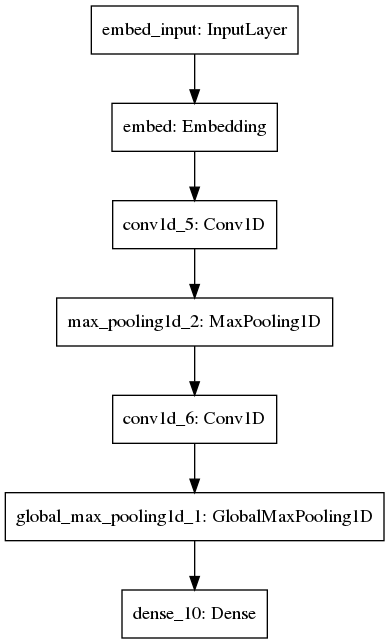

In [20]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='imgs/model.png')
Image(filename='imgs/model.png')

> You also have the option of displaying shape information in the graph of layers:

你也可以指定参数用来展示层次的形状：

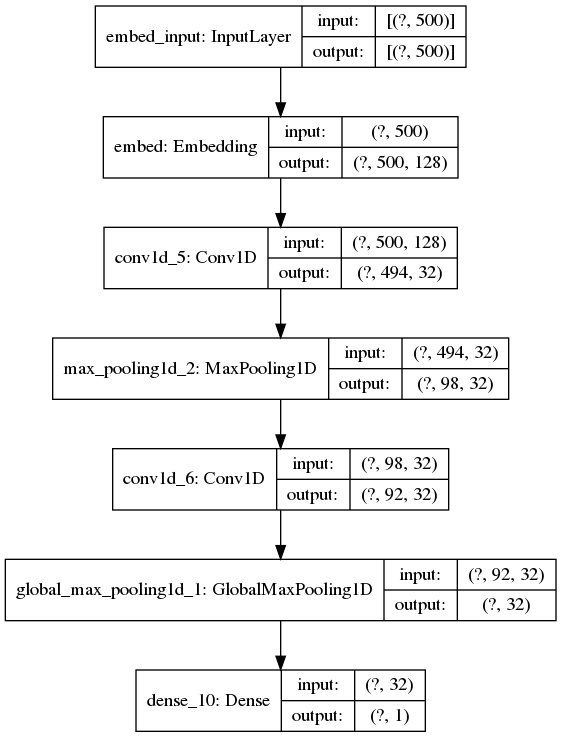

In [21]:
plot_model(model, show_shapes=True, to_file='imgs/model.png')
Image('imgs/model.png')

### 7.2.3 小结

> - Keras callbacks provide a simple way to monitor models during training, and
automatically take action based on the state of the model.
- When using TensorFlow, TensorBoard is a great way to visualize model activity in your
browser. You can use it in Keras models via the TensorBoard callback.

- Keras回调提供了一个简单的方法来监控训练时的模型情况，并能根据模型的状态自动采取行动。
- 当使用TensorFlow的时候，TensorBoard是一个能够在浏览器中可视化模型行为的好工具。你可以在Keras模型中使用TensorBoard回调。

## 7.3 让模型发挥最大作用

> Trying out architectures blindly works well enough if you just need something that works
okay. Here we go beyond "works okay" into "works great and wins machine learning
competitions". Here’s a quick explainer on a set of must-know techniques for building
state-of-the-art deep learning models.

如果只是需要模型工作良好的话，漫无目的地尝试各种结构确实也能够满足要求。本节中我们要超越“工作良好”，变为“工作优异并能赢得机器学习竞赛”。因此我们会介绍一些必须知晓的深度学习模型构建技巧。

### 7.3.1 高级结构模式

> We’ve already covered one important design pattern in detail in the previous section:
residual connections. Here are two more that you should know about. These patterns are
especially relevant when building high-performing deep convnets. However, they are
commonly found in many other types of architectures as well.

在前面的小节中我们已经详细介绍了一个重要的设计模式：残差连接。下面还有两个模式需要了解。这些模式在构建高性能深度卷积网络特别有效。但它们在其他类型结构中也可以看到。

#### 批次正规化

> "Normalization" is a broad category of methods that seek to make different samples seen
by a machine learning model more similar to each other, which helps the model learn and
generalize well to new data. The most common form of data normalization is one that
you have already encountered several times in this book already: centering the data on 0
by subtracting the mean from the data, and giving it a unit standard deviation by dividing
the data by its standard deviation. In effect, this makes the assumption that the data
follows a normal (or Gaussian) distribution, and makes sure that this distribution is
centered and scaled to unit variance.

“正规化”是一大类广泛使用的手段，用来使得机器学习模型观测到的不同样本尽可能的处于一致的取值范围，这样能够帮助模型更好的学习和增强对新数据的泛化能力。数据的正规化的最通用方式之一是我们在前面已经介绍过的方法：将数据减去其均值从而使得其均值点处于零点，然后将数据除以标准差从而使得新的标准差具有单位标准差。这样做的前提是假设数据符合正态（或高斯）分布，而且分布是按照中心点具有单位偏差延伸的。

```python
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
```

> In previous examples, we were only normalizing data before feeding it into our
models. However, data normalization should still be a concern after every transformation
operated by the network: even if the data coming in a Dense or Conv2D network has
0-mean and unit variance, there are no reasons to expect a priori that this will still be the
case for the data coming out.

在前面的那些例子中，我们仅在数据输入到模型之前进行了正规化。可是当数据在网络中被处理后仍然存在正规化的问题：即使这些数据在传递到全连接层或者Conv2D卷积层时是0均值和单位偏差的情况下，我们依然无法依据先验知识确定这些数据从层次运算得到输出之后依旧保持着正规化。

> Batch normalization is a type of layer ( BatchNormalization in Keras) introduced in
2015 by Ioffe and Szegedy, capable of adaptively normalizing data even as its mean and
variance change over time during training. It works by internally maintaining an
exponential moving average of the batch-wise mean and variance of the data seen during
training. The main effect of batch normalization is that it helps with gradient
propagation—much like residual connections—and thus it allows for deeper networks.
Some very deep networks can only be trained if they include multiple
BatchNormalization layers. For instance, BatchNormalization is used liberally in
many of the advanced convnets architectures that come packaged with Keras, such as
ResNet50, InceptionV3 and Xception.

批次正规化是一种层（Keras中的`BatchNormalization`），在2015年由Ioffe和Szegedy首先提出，能够自适应地对数据进行正规化，即使在这些数据在训练过程中随时间不断变化着均值和偏差的情况下。它的工作原理是在训练过程中内部维护一个每个批次的均值和偏差的指数平均值。批次正规化的主要效果是它能帮助梯度传播，就像残差连接那样，因此可以允许更深的网络存在。有一些非常深的网络只能在其中有批次正规化层的情况下才能进行训练。例如批次正规化经常使用在很多高级的卷积网络结构中，在Keras内置的一些网络里面也可以看到它，比方说ResNet50，InceptionV3和Xception。

> The BatchNormalization layer is typically used after a convolutional or
densely-connected layer:

批次正规化层通常在卷积层或者全连接层后使用：

```python
conv_model.add(layers.Conv2D(32, 3, activation='relu'))
conv_model.add(layers.BatchNormalization())

dense_model.add(layers.Dense(128, activation='relu'))
dense_model.add(layers.BatchNormalization())
```

> The BatchNormalization layer takes an axis argument, which specifies the
features axis which should be normalized. This argument defaults to -1 , the last axis in
the input tensor. This is the correct value when using Dense layers, Conv1D layers, RNN
layers, as well as Conv2D layers with data_format set to "channels_last". However, in
the niche use case of Conv2D layers with data_format set to "channels_first", the
features axis is axis number 1 , and the axis argument in BatchNormalization should
then be set to 1 accordingly.

批次正规化层实例化接受一个axis参数，用来指定应该正规化的特征维度。参数默认值是-1，也就是输入张量的最后一个维度。这个默认值对于全连接层、Conv1D层、RNN层和数据格式是“通道最后”的Conv2D层都是正确的。但是如果在“通道优先”的Conv2D层中，特征维度的值应该为1，所以参数值就应该设置为1.

> A recent improvement over regular batch normalization has been "batch
renormalization", introduced by Ioffe in 2017. It offers clears benefits over batch
normalization, at no apparent cost. It is still too early to tell, as I am writing these lines,
whether it will come to completely supplant batch normalization—but I would say it is
rather likely. Even more recently, Klambauer et al introduced "self-normalizing neural
networks", which manage to keep data normalized after going through any Dense layer,
by using a specific activation function ( selu ) and a specific initializer ( lecun_normal ).
This scheme, while highly interesting, is limited to densely-connected networks for now,
and its usefulness has not yet been broadly replicated.

对常规批次正规化的一个最新的改进是“批次重正规化”，由Ioffe在2017年提出。它提供了相对批次正规化明显的优点，又没有带来明显的损耗。当作者写这本书的时候，还不能确定的说这会完全取代批次正规化，但作者认为这是非常可能的。最近由Klambauer等提出的“自正规化神经网络”，能够提供一种在通过任何全连接层之后都保持数据正规化的方式，它使用了一种特定的激活函数`selu`和一种特定的初始化`lecun_normal`。这个方法，很吸引人，不过还只是限制在全连接网络当中，因此它的作用还需要更加广泛的扩展。

#### 深度可分卷积

> What if I told you that there is a layer you can use as a drop-in replacement for Conv2D ,
that will make your model lighter (fewer trainable weight parameters), faster (fewer
floating point operations), and perform a few percent better on its task? That is precisely
what the depthwise separable convolution layer does ( SeparableConv2D ). A depthwise
separable convolution performs a spatial convolution on each channel of its input,
independently, before mixing output channels via a "pointwise" convolution (a 1x1
convolution). This is equivalent to separating the learning of spatial features and the
learning of channel-wise features, which makes a lot of sense if you assume that spatial
locations in the input are highly correlated, while its different channels are fairly
independent. It requires significantly fewer parameters, and involves fewer computations,
thus resulting in smaller and speedier models. And because it’s a more representationally
efficient way to perform convolution, it tends to learn better representations using less
data, resulting in better-performing models.

如果我告诉你有一种模型层次，能够用来代替Conv2D，它能使得你的模型更加轻量（更少的可训练权重参数），更加快速（更少的浮点数运算），并且能在同样的任务上获得几个点的性能提升，那就是深度可分卷积层了（`SeparableConv2D`）。一个深度可分卷积会对输入中的每一个通道独立进行空间卷积，然后通过“点卷积”（1x1卷积）将输出通道混合起来。这实际上等同于将空间特征学习和通道特征学习分离，这在假设输入的空间位置是高度相关而不同的通道是相对独立的情况下，是非常有道理的。深度可分卷积需要相对较少的参数，并且涉及更少的计算，因此可以构建一个更小型和快速的模型。因为这是一种更加具有表现性的有效卷积方式，因此深度可分卷积能够使用更少的数据来获得更好的性能。

![深度可分卷积](imgs/f7.16.png)

图7-16 深度可分卷积：一个独立通道深度卷积然后是一个空间点卷积

> These advantages become especially important when training small models from
scratch on limited data. For instance, here is how you would build a lightweight
depthwise separable convnet for an image classification task (softmax categorical
classification) on a small dataset:

深度可分卷积的这些特性对于从头搭建一个小训练集的小型网络来说是特别重要的。例如，下面就是一个构建轻量深度可分卷积网络来对图像进行分类（softmax分类）的例子，使用了一个小型数据集：

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

num_classes = 100

model = Sequential()

model.add(SeparableConv2D(32, 3, activation='relu', input_shape=(300, 400, 4)))
model.add(SeparableConv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))

model.add(SeparableConv2D(64, 3, activation='relu'))
model.add(SeparableConv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))

model.add(SeparableConv2D(64, 3, activation='relu'))
model.add(SeparableConv2D(128, 3, activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_7 (Separabl (None, 298, 398, 32)      196       
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 296, 396, 64)      2400      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 148, 198, 64)      0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 146, 196, 64)      4736      
_________________________________________________________________
separable_conv2d_10 (Separab (None, 144, 194, 128)     8896      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 97, 128)       0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 70, 95, 64)       

> When it comes to larger-scale models, depthwise separable convolutions are the basis
of the Xception architecture, a high-performing convnet that comes packaged with Keras.
You can read more about the theoretical grounding for depthwise separable convolutions
and Xception in my paper "Xception: deep learning with depthwise separable
convolutions" (CVPR 2017).

当讨论大型模型时，深度可分卷积是Xception结构的基础组成部分，这是Keras内置的一个强大的卷积网络。你可以通过作者在CVPR 2017上的论文《Xception：使用深度可分卷积的深度学习网络》，来进一步了解深度可分卷积和Xception的原理。

### 7.3.2 超参数优化

> When building a deep learning model, there are many seemingly arbitrary decisions that
you have to make: how many layers should you stack? How many units or filters should
go into each layer? Should you use relu as activation, or a different function? Should
you use BatchNormalization after a given layer? How much dropout should you use?
And so on... These architecture-level parameters are called "hyperparameters", to
distinguish them from the parameters of a model, which are trained via backpropagation.

当构建一个深度学习模型时，存在着很多看起来需要你随机决定的选择：应该使用多少层次来堆叠模型？每个层次需要多少个单元和过滤器？应该使用`relu`还是其他的激活函数？在一个层次后是否需要使用批次正规化？应该使用多少比例的`dropout`？等等等等......这些结构上的参数被称为“超参数”，用于区别在训练过程中通过反向传播更新的普通模型权重参数。

> In practice, experienced machine learning engineers and researchers are able to build
some intuition over time as to what works and what doesn’t when it comes to these
choices—they develop "hyperparameter tuning" skills. But there are no formal rules. If
you want to get to the very limit of what can be achieved on a given task, you cannot just
be content with arbitrary choices made a fallible human. Your initial decisions are almost
always suboptimal, even if you have a good intuition. You could refine them by tweaking
your choices by hand and retraining your model repeatedly—in fact, that’s what machine
learning engineers and researchers spend most of their time on. But it shouldn’t be your
job as a human to fiddle with hyperparameters all day—that is better left to a machine.

在实践中，有经验的机器学习工程师和研究人员都能够从它们日常的工作培养出哪些参数可能有效或者无效的直觉，也就是说它们发展出了“超参数调优”的技巧。但是这个领域并没有正式的规则。如果你希望在某个特定的任务上获得最佳的性能，那就不能满足于使用随机的选择。通常来说你的第一个选择都不是最优的，即便是你在这个领域已经建立的良好的直觉也一样。几乎所有情况下，你都需要多次重复调整优化参数然后重新训练模型的过程，事实上，这就是机器学习工程师和研究人员消耗时间最多的工作过程。但是这不代表着这种调整超参数的工作应该都是人工完成，而事实上机器协助完成这个任务会更加适合。

> Thus, you need to explore the space of possible decisions automatically,
systematically, in a principled way. You need to search through architecture space, and
find the best performing ones empirically. That’s what the field of automatic
hyperparameter optimization is about—it’s an entire field of research, and an important
one.

因此你需要使用一种正路的方法来自动化系统化的探索参数可能的取值空间。需要搜索结构空间然后凭经验来找到最好性能的那个。这就是自动化超参数优化技术的意义，这是一个相当大的研究领域，也是很重要的一个。

> The process of optimizing hyperparameters typically looks like this:

> - Pick a set of hyperparameters (automatically).
- Build the corresponding model.
- Fit it to your training data, and measure the final performance on the validation data.
- Pick the next set of hyperparameters to try (automatically).
- Repeat. ...
- Eventually measure performance on your test data.

超参数优化的典型流程如下：

- 选择一套超参数（自动化）
- 构建相应的模型
- 使用训练数据来训练模型，然后使用验证数据来衡量模型的性能
- 重新选择一套超参数（自动化）
- 重复以上过程
- 最终在测试数据上衡量模型的性能

> The key to this process is the algorithm that uses this history of validation
performance given various sets of hyperparameters to pick the next set of
hyperparameters to evaluate. Many different techniques are possible: bayesian
optimization, genetic algorithms, simple random search...

这个过程中的关键点就是利用给定的不同超参数集的性能记录来计算并选择下一个超参数集的算法。有许多不同可能的技巧：贝叶斯优化，遗传算法，简单随机搜索...

> Training the weights of a model is relatively easy: you compute a loss function on a
mini-batch of data, then use the backpropagation algorithm to move the weights in the
right direction. Updating hyperparameters, on the other hand, is extremely challenging.
Indeed, consider that:

> - Computing the feedback signal (does this set of hyperparameter lead to a
high-performing model on this task?) can be extremely expensive: it requires creating
and training a new model from scratch on your dataset.
- The hyperparameter space is typically made of discrete decisions, and is thus not
continuous, not differentiable. Hence, one typically cannot do gradient descent in
hyperparameter space. Instead, one has to rely on gradient-free optimization techniques,
which naturally are far less efficient than gradient descent.

训练模型的权重相对比较容易：通过模型计算得到一个批次数据的损失函数，然后使用反向传播算法来更新网络权重。然而更新超参数却特别具有挑战性。比如：

- 计算反馈信号（这一套超参数是否在这个任务上能获得更优秀的性能？）将会非常昂贵：一次计算需要构建模型并且在数据集上重新训练一次新的模型。
- 超参数空间通常是由离散的数值组成的，因此不是连续的，也就是不可微的。所以我们无法在超参数空间中使用梯度下降。这里需要非梯度优化的技巧，这些技巧一般都远没有梯度下降算法效率高。

> Because these challenges are hard and the field is still young, we currently only have
access to very limited tools to optimize our models. Often, it turns out that random search
(picking the hyperparameters to evaluate at random, repeatedly) is the best solution,
despite being the most naive one. However, one tool that I have found reliably better than
random search is Hyperopt , a Python library for hyperparameter optimization which
internally uses trees of Parzen estimators to predict sets of hyperparameters that are likely
to work well. Another library called Hyperas integrates Hyperopt for use with Keras
models. Do check it out.

上述这些挑战都非常困难，且这个领域还很新，我们目前只有很有限的工具可以用来优化我们的模型。通常情况下，随机搜索（重复的随机选取超参数）都是最好的方案，尽管这是一个最简单的算法。但是作者发现有一个工具叫做`Hyperopt`，能可靠地超越随机搜索算法，这是一个Python的库用于超参数优化，其原理是使用树型的Parzen评估器来预测超参数套是否能够改进模型性能。还有一个叫做`Hyperas`的库继承了Hyperopt和Keras模型。都推荐读者去了解一下。

> One very important issue to keep in mind when doing automatic hyperparameter
optimization at scale, is that of validation set overfitting. Since you are updating your
hyperparameters based on a signal that is computed using your validation data, you are
effectively training them on the validation data, and thus they will quickly overfit to the
validation data. Always keep this in mind.

这里有一个非常重要的问题需要说明的是，大规模使用自动化超参数优化时，必须防止验证集过拟合。因为这个过程是通过计算验证数据获得的结果作为信号来更新模型的超参数的，其实相当于你使用了验证数据来训练了你的模型，因此它可能会很快的对验证数据发生过拟合。必须牢记这点。

> Overall—hyperparameter optimization is a powerful technique that is an absolute
requirement to get to state-of-the-art models on any task, or to win machine learning
competitions. Think about it: once upon a time, people would handcraft the features that
went into shallow machine learning models. That was very much suboptimal. Now deep
learning automates the task of hierarchical feature engineering—features are now learned
using a feedback signal, not hand-tuned, and that’s the way it should be. In the very same
way, we should not handcraft our model architectures, we should optimize them in a
principled way. As I write these lines, the field of automatic hyperparameter optimization
is still very young and immature, as deep learning was some years ago, but I would
expect it to boom in the next few years.

总的说来，超参数优化是你需要在某个任务上得到最优模型或者赢得机器学习竞赛所必须的强大技巧。设想一下，之前人们都是手动选择浅机器学习模型权重参数来拟合数据的特征，这种方法是非优化的。现在的深度学习已经能够自动化这个过程，层次化的权重特征可以从反馈信号中学习得到，而不是手动调整，这才是正确的方式。类似的，我们不应该手动调整模型的结构，而是通过更加正规的方法来学习获得。在做着写这本书的时候，这个超参数优化领域还非常年轻和不成熟，就像深度学习在若干年前那样，但是作者预计它将会在接下来几年中爆发。

### 7.3.3 模型组装

> One last powerful technique for obtain the best possible results on a task is model
ensembling . Ensembling consists in pooling together the predictions of a set of different
models, in order produce better predictions. If you look at machine learning competitions
out there, in particular on Kaggle, in all of them the winners are using very large
ensembles of models, which inevitable beat any single model, no matter how good.

最后一个获得模型最优性能的强大技巧是模型组装。组装是将一组不同模型的预测汇集在一起，以期获得更好的预测。如果你有观看过机器学习的竞赛，特别是Kaggle，就会发现所有获胜者都大量使用了模型组装，它能碾压单个模型，无论优化程度多少。

> Ensembling relies on the assumption that different good models trained independently
are likely to be good for different reasons : each model is looking at slightly different
aspects of the data to make its predictions, getting hold of part of the "truth", but not all
of it. You may be familiar with the parable of the blind men and the elephant: an ancient
story of a group of blind men who come across an elephant for the first time, and try to
understand what the elephant is by touching it. Each man touches a different part of the
elephant’s body—just one part, such as the trunk, or a leg. Then the men describe to each
other what an elephant is: "it’s like a snake", "like a pillar or a tree"... These blind men
are essentially machine learning models trying to understand the manifold of the training
data, each from its own perspective, using its own assumptions (provided by the unique
architecture of the model and the unique random weight initialization). Each of them gets
part of the truth of the data, but not the whole truth. By pooling their perspectives
together, one can get a far more accurate description of the data. The elephant is a
combination of parts: not any single blind man gets it quite right, but interviewed
together, they can tell a fairly accurate story.

组装基于这样一个假设，就是不同优秀的独立训练模型都有着各自优秀的领域：每个模型都观察了数据的不同方面来做出它的预测，因此它们都得到了“真相”的部分，而不是全部。你可能很熟悉盲人摸象的故事：一群盲人都是从来没有接触过大象，然后各自触摸大象身体的不同部位，例如鼻子、腿等，并且通过各自的接触来描述大象。他们对于大象的描述会非常不同：“大象像一条蛇”，“大象像一个树桩”......这些盲人对大象的理解就像机器学习模型对训练数据多样性的理解一样，每个都有着自己的片面观点，使用的是本身的假设（模型具有独特的结构和初始化权重参数）。因此每个模型都只掌握了真相的一部分，而不是全部。如果能够将这些部分汇集在一起，那么就能够得到数据更加准确的描述。大象是一个各部分观察的结合：其中任何一个盲人都没有完全正确的描述它，但是将这些结果组装起来，他们能够获得一个相对准确的描述。

> Let’s use classification as an example. The easiest way to pool together the
predictions of a set of classifiers (to "ensemble the classifiers") is to average their
predictions at inference time:

如果我们使用分类作为例子。对一组分类器的预测进行聚合（“组装分类器”）的最简单方法就是在推断的时候对它们所有的预测取平均值：

```python
predict_a = model_a.predict(x_val)
predict_b = model_b.predict(x_val)
predict_c = model_c.predict(x_val)
predict_d = model_d.predict(x_val)

# 最终采用均值来作为预测值
final_preds = .25 * (predict_a + predict_b + predict_c + predict_d)
```

> This will only work if the classifiers are more or less equally good. If one of their is
significantly worse than the other, then the final predictions may not be as good as the
best classifier of the group.

这个方法只能在所有的分类器性能基本一致时有效。如果其中有一个分类器的性能明显低于其它的分类器，那得到的最终结果可能还不如其中最优分类器的预测。

> A smarter way to ensemble classifiers is to do a weighted average, where the weights
are learned on the validation data—typically the better classifiers will be given a higher
weight, and the worse classifiers will be given a lower weight. To search for a good set of
ensembling weights, one could use random search, or a simple optimization algorithm
such as Nelder-Mead.

一个更聪明的方法是使用加权平均来聚合所有分类器的预测，这里的权重来自于模型在验证集上的表现，更确切的说，更好的分类器给予更高的权重，而表现不好的分类器给予更低的权重值。要找到这样一组合适的聚合权重值，可以使用随机搜索或例如`Nelder-Mead`这样的简单优化算法。

```python
predict_a = model_a.predict(x_val)
predict_b = model_b.predict(x_val)
predict_c = model_c.predict(x_val)
predict_d = model_d.predict(x_val)

# 下面的权重值是基于优化结果假设得到的
final_preds = .5 * predict_a + .25 * predict_b + .1 * predict_c + .15 * predict_d
```

> There are many possible variants one can imagine: you could do an average of an
exponential of the predictions, for instance. In general, a simple weighted average with
weights optimized on the validation data provides a very strong baseline.

还有很多可能的聚合算法可以考虑：例如可以使用预测的指数平均。在大多数情况下，前面看到的加权平均方法都能提供一个强大的基线准则。

> The key to making ensembling work is the diversity of the set of classifiers. Diversity
is strength. If all of your blind men had only touched the elephant’s trunk, they would
agree that elephants are like snakes, and would forever stay ignorant of the truth of the
elephant. Diversity is what makes ensembling work. In machine learning terms, if all of
your models are biased in the same way, then your ensemble will retain this same bias. If
your models are biased in different ways , the biases will cancel each other out and the
ensemble will be more robust and more accurate.

模型组装能够成功的关键在于这些分类器的多样性。这里的多样性非常重要。如果所有盲人都知识接触到了大象鼻子，他们都将会同意大象像一条蛇，并且永远无法产生接近真相的描述。因此多样性是使得组装能够提升模型性能的关键因素。在机器学习术语中，如果所有的模型都朝相同方向发生了偏差，那么组装的结果仍然会保留相同的偏差。如果模型能够在不同的方向上发生偏差，那么最终组装的结果能够互相抵消这些偏差，并且使得结果更加的鲁棒和准确。

> For this reason, you should be ensembling models that are as good as possible while
being as different as possible . This typically means using very different architectures or
even different brands of machine learning approaches altogether. One thing that is largely
not worth doing, is ensembling a same network trained several times independently, from
different random initializations. If the only difference between your models is their
random initialization and the order in which they have been exposed to the training data,
then your ensemble will be low-diversity and will only provide a tiny improvement over
any single model.

正因为此，你应该组装那些尽可能不同的模型。这通常表示这些模型使用了完全不同的结构或者完全异质的机器学习算法。这里要说明使用不同的初始化参数在相同的模型上进行多次独立的训练，然后组装到一起这种做法是完全没有必要的。如果用来组装的模型仅在初始化参数和它们观察数据的顺序上有区别，那么这种组装的多样性是很低的，最多仅能提供非常微弱的性能改善。

> One thing that I have found to work well in practice—but which does not generalize
to every problem domain—is the use of an ensemble of tree-based methods (such as
random forests or gradient boosted trees) and deep neural networks. In 2014, partnering
with Andrei Kolev, I took the fourth place in the Higgs Boson decay detection challenge
on Kaggle using an ensemble of various tree models and deep neural networks.
Remarkably, one of the models in the ensemble originated from a quite different method
than the others (it was a Regularized Greedy Forest), and had a significantly worse score
than the others. Unsurprisingly, it was assigned a small weight in the ensemble. But to
my surprise, it turned out to improve the overall ensemble by a large factor, simply
because it was so different from every other model: it provided information that the other
models did not have access to. That’s precisely the point of ensembling. It’s not so much
about how good your best model is, it is about the diversity of your set of candidate
models.

作者发现了一个实践中模型组装工作的很理想的领域，但是这个方法未必适合所有任务，那就是将树型机器学习方法（例如随机森林或者梯度增强树）和深度神经网络组装起来。作者在2014年与Andrei Kolev合作获得了Kaggle上希格斯玻色子衰减检测竞赛的第四名，使用的正是将不同的树型模型和深度神经网络进行组装的技术。这里需要着重指出的是，用来进行组装的模型中，有一种和其他的区别非常大，作者使用了正则化贪婪森林（RGF），它独立预测的结果远远低于其他模型。不出意外的是，计算最终预测结果时，这个模型的预测被赋予了很小的权重值。但是出乎意料的是，这个模型的加入极大的改进了最终性能，仅仅是因为它与其它模型具有很大的区别：它提供了一些其它模型训练时没有接触到的信息。这就是组装的意义所在。它不在于最佳性能模型表现有多好，而在于这些组装的模型的多样性。

> In recent times, one style of basic ensemble that has been very successful in practice
is the "wide and deep" category of models, blending deep learning with shallow learning,
consisting in jointly training a deep neural net with a large linear model. The joint
training of a family of diverse models is yet another option to achieve model ensembling.

最近出现了一种实践中非常成功的模型组装方式，叫做“宽且深”模型组合，通过混合深度学习和浅学习，然后对一个深度神经网络和一个大型线性模型进行联合训练。联合训练也是另外一类除了模型组装外利用模型多样达到目的的方法。

### 7.3.4 小结

> - When building high-performing deep convnets, you will need to leverage residual
connections, batch normalization, and depthwise separable convolutions. In the future, it
is likely that depthwise separable convolutions will end up completely replacing regular
convolutions, whether for 1D, 2D or 3D applications, due to their higher representational
efficiency.
- Building deep nets requires making many small hyperparameter and architecture choices,
which together define how good your model will end up being. Rather than basing these
choices on intuition or random chance, it is better to systematically search through
hyperparameter space to find optimal choices. At this time, the process is expensive, and
the tools to do it are not very good. But maybe the Hyperopt or Hyperas libraries can help
you. When doing hyperparameter optimization, be mindful of validation set overfitting!
- Winning machine learning competitions or otherwise obtaining the best best possible
results on a task can only be done with large ensembles of models. Ensembling via a
well-optimized weighted average is usually good enough. Remember: diversity is
strength; it is largely pointless to ensemble very similar models, the best ensembles are
set of models that are as dissimilar as possible (while having as much predictive power as
possible, naturally).

- 当构建高性能深度卷积网络时，你可能需要用到残差连接、批次正规化和深度可分卷积。在将来很可能深度可分卷积会完全取代常规卷积，无论是在1D，2D还是3D场景中，因为它们具有相当高的表现效率。
- 构建深度学习模型需要对超参数和结构做出很多选择，这些选择都会影响到模型最终的性能。与其根据直觉或者随机来选择参数，更好的方式是系统性的在超参数空间中进行搜索以获得优化选择。在目前的情况下，这个过程非常昂贵，而且可用的工具也不是特别好。但是也许`Hyperopt`或`Hyperas`库能够对你有一定帮助。当进行超参数优化时，必须注意防止验证集过拟合！
- 如果想要赢得竞赛或者榨干所有模型的性能，模型组装是必须的技巧。通过一个优化的权重集来对结果进行组装在大多数情况下都能获得足够优秀的结果。要记住在模型组装中，多样性是关键，组装相似模型的做法是没有必要的，最佳实践是尽可能组装那些完全不同的模型（当然这些模型也应该能够尽量获得最佳的结果）。

## 7.4 总结：高级深度学习最佳实践

> In this chapter, you have learned:

> - How to build models as arbitrary graphs of layers.
- How to reuse layers ("layer weight sharing").
- How to use models as Python functions ("model templating").
- How to use Keras callbacks to monitor your models during training and take action based
on model state.
- How to use TensorBoard to visualize metrics, activation histograms, and even embedding
spaces.
- What Batch Normalization, Depthwise Separable Convolution, and Residual Connections
are.
- Why you should use hyperparameter optimization and model ensembling.

在本章中，你应该学习到：

- 如何构建自定义的图网络
- 如何重用层（“层权重共享”）
- 如何使用Keras回调来监控模型训练和根据模型状态采取措施
- 如何使用TensorBoard来可视化训练指标，激活直方图，甚至是嵌入空间
- 什么是批次正规化，深度可分卷积和残差连接
- 为什么你需要使用超参数优化和模型组装

> With these new tools, you are better equipped to use deep learning in the real world
and start building highly competitive deep learning models.

有了这些新的工具，你就能够更好的开发实际生活中的深度学习模型，并且能够着手构建具有竞争力的深度学习模型。

<< [第六章：文本和序列的深度学习](Chapter6_Deep_learning_for_text_and_sequences.ipynb)|| [目录](index.md) || [第八章：生成模型深度学习](Chapter8_Generative_deep_learning.ipynb) >>